In [ ]:
import deepxde as dde
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import cm
import os

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term



# Formulation of the Problem
Our goal is to predict the solution of the acoustic wave equation. The formulation can be written as follows:

\begin{align}
\frac{\partial^2 u}{\partial t^2} = c^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
    \end{align}

$c = \sqrt{30/2.7} = 3.33$

Initial Conditions:
\begin{align}
u(x, y, 0) = x(1-x)y(1-y) \\
\frac{\partial u}{\partial t}(x, y, 0) = 0
    \end{align}

Boundary Conditions:
$u(0, y, t) = u(1, y, t) = u(x, 0, t) = u(x, 1, t) = 0$


In [2]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    dy_tt = dde.grad.hessian(y, x, i=2, j=2)
    return dy_tt - C**2 * (dy_xx + dy_yy)

def get_initial_loss(model):
    model.compile("adam", lr=0.001)
    losshistory, train_state = model.train(0)
    return losshistory.loss_train[0]

def func(x):
    x, y, t = np.split(x, 3, axis=1)
    return x*(1-x)*y*(1-y)

# Neural Network Setup and Train Model

- **Parameter Definition:**  
  - `C = np.sqrt(30/2.7)` computes the constant `C`.

- **Domain Setup:**  
  - **Spatial Domain:** Defined as `[0, 1] × [0, 1]` with `dde.geometry.Rectangle`.
  - **Time Domain:** Defined as `[0, 0.01]` with `dde.geometry.TimeDomain` (note the comment suggests `[0, 0.1]`).
  - **Spatio-Temporal Domain:** Combined using `dde.geometry.GeometryXTime`.

- **Boundary and Initial Conditions:**  
  - **Dirichlet BC:** `bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)`
  - **Initial Condition:** `ic_1 = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)`
  - **Operator BC:** Applies a derivative condition via `dde.icbc.OperatorBC`.

- **Training Data and Loss Setup:**  
  - The PDE data is prepared with `dde.data.TimePDE`, specifying numbers for domain, boundary, initial, and test points.

- **Neural Network Configuration:**  
  - **Architecture:** `layer_size = [3] + [100] * 3 + [1]` (3 inputs, three hidden layers of 100 neurons each, 1 output).
  - **Activation & Initializer:** Uses `"tanh"` activation and `"Glorot uniform"` initializer.
  - **Network Creation:** Built with `dde.nn.STMsFFN` and enhanced by a feature transformation.
  - **Model Assembly:** Combined into a model via `dde.Model(data, net)`.

- **Compilation and Training:**  
  - **Loss Weighting:** Computed using `get_initial_loss(model)` and scaled as `loss_weights = 5 / initial_losses`.
  - **Compilation:** Model is compiled with the Adam optimizer, a learning rate of `0.001`, and an inverse time decay schedule.
  - **Callbacks:** Includes a model checkpoint callback (saving every 50 iterations) and a PDE residual resampler (every 100 iterations).
  - **Training:** The model trains for 10,000 iterations with periodic display every 500 iterations.

- **Post-Training:**  
  - The training history and state are saved and plotted using `dde.saveplot`.


In [ ]:
# Define parameter c
C = np.sqrt(30/2.7)

# Spatial domain: X × Y = [0, 1] × [0, 1]
Lx_min, Lx_max = 0.0, 1.0
Ly_min, Ly_max = 0.0, 1.0
space_domain = dde.geometry.Rectangle([Lx_min, Ly_min], [Lx_max, Ly_max])

# Time domain: T = [0, 0.1]
time_domain = dde.geometry.TimeDomain(0.0, 0.01)

# Spatio-temporal domain
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

# Define BCs and ICs
bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic_1 = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)
ic_2 = dde.icbc.OperatorBC(
    geomtime,
    lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=2),
    lambda x, _: dde.utils.isclose(x[2], 0),
)

# Training datasets and Loss
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic_1, ic_2],
    num_domain=360,
    num_boundary=2000,
    num_initial=2000,
    num_test=10000,
)

# Neural network setup
layer_size = [3] + [100] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.STMsFFN(
    layer_size, activation, initializer, sigmas_x=[1, 10], sigmas_t=[1, 10]
)
net.apply_feature_transform(lambda x: (x - 0.5) * 2 * np.sqrt(3))
model = dde.Model(data, net)
initial_losses = get_initial_loss(model)
loss_weights = 5 / initial_losses
model.compile(
    "adam",
    lr=0.001,
    loss_weights=loss_weights,
    decay=("inverse time", 2000, 0.9),
)
path = "./../output/forward_acoustic_wave/model"
os.makedirs(path, exist_ok=True)
checkpoint_path = os.path.join(path, "model.ckpt")
checker = dde.callbacks.ModelCheckpoint(
      checkpoint_path, save_better_only=True, period=50
  )
pde_residual_resampler = dde.callbacks.PDEPointResampler(period=100)
losshistory, train_state = model.train(
    iterations=10000,  callbacks=[checker, pde_residual_resampler], display_every=500
)

dde.saveplot(losshistory, train_state, issave=True, isplot=True, output_dir="./../output/forward_acoustic_wave/")


Compiling model...
Building Spatio-temporal Multi-scale Fourier Feature Network...
'compile' took 6.037308 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [6.36e+07, 6.37e-02, 7.11e-02, 6.13e+01]    [6.41e+07, 6.37e-02, 7.11e-02, 6.13e+01]    []  

Best model at step 0:
  train loss: 6.36e+07
  test loss: 6.41e+07
  test metric: []

'train' took 2.500062 s

Compiling model...
'compile' took 4.563274 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [7.91e+00, 6.19e+00, 6.69e+00, 4.72e+00]    [8.02e+00, 6.19e+00, 6.69e+00, 4.72e+00]    []  
INFO:tensorflow:./../output/forward_acoustic_wave/model\model.ckpt-50.ckpt is not in all_model_checkpoint_paths. Manually adding it.
INFO:tensorflow:./../output/forward_acoustic_wave/model\model.ckpt-50.ckpt.data-00000-of-00001
INFO:tensorflow:300
INFO:tensorflow:./..

KeyboardInterrupt: 

# Prediction and Plotting

- **Grid Definition:**  
  - `x = np.linspace(0, 1, 101)` and `y = np.linspace(0, 1, 101)` create 101 points for spatial dimensions.
  - `t = np.linspace(0, 0.01, 101)` creates 101 time points between 0 and 0.01.

- **Meshgrid Creation:**  
  - `xv, yv, tv = np.meshgrid(x, y, t)` generates 3D grids for x, y, and t.

- **Flattening the Grids:**  
  - `x_test`, `y_test`, and `t_test` are column vectors obtained by flattening `xv`, `yv`, and `tv`, respectively.

- **Combining Coordinates:**  
  - `ob_xyt = np.hstack((x_test, y_test, t_test))` stacks the flattened arrays into a single array of (x, y, t) points.

- **Model Prediction and Reshaping:**  
  - `pred = model.predict(ob_xyt)` computes the model's prediction on the test points.
  - `pred2 = pred.reshape((101,101,101))` reshapes the predictions back into a 3D grid matching the original meshgrid dimensions.


In [4]:
x = np.linspace(0, 1, 101)
y = np.linspace(0, 1, 101)
t = np.linspace(0, 0.01, 101)
xv, yv, tv = np.meshgrid(x, y, t)

x_test = xv.flatten()[:,None]
y_test = yv.flatten()[:,None]
t_test = tv.flatten()[:,None]

ob_xyt = np.hstack((x_test, y_test, t_test))
pred = model.predict(ob_xyt)
pred2 = pred.reshape((101,101,101))

In [5]:
data = loadmat('../Dataset/acoustic_c3.mat')
u_exact = data['u_log'].transpose(1, 0, 2)
tspan = data['t'].T

Text(0.5, 0.98, 'Prediction at t = 0.01')

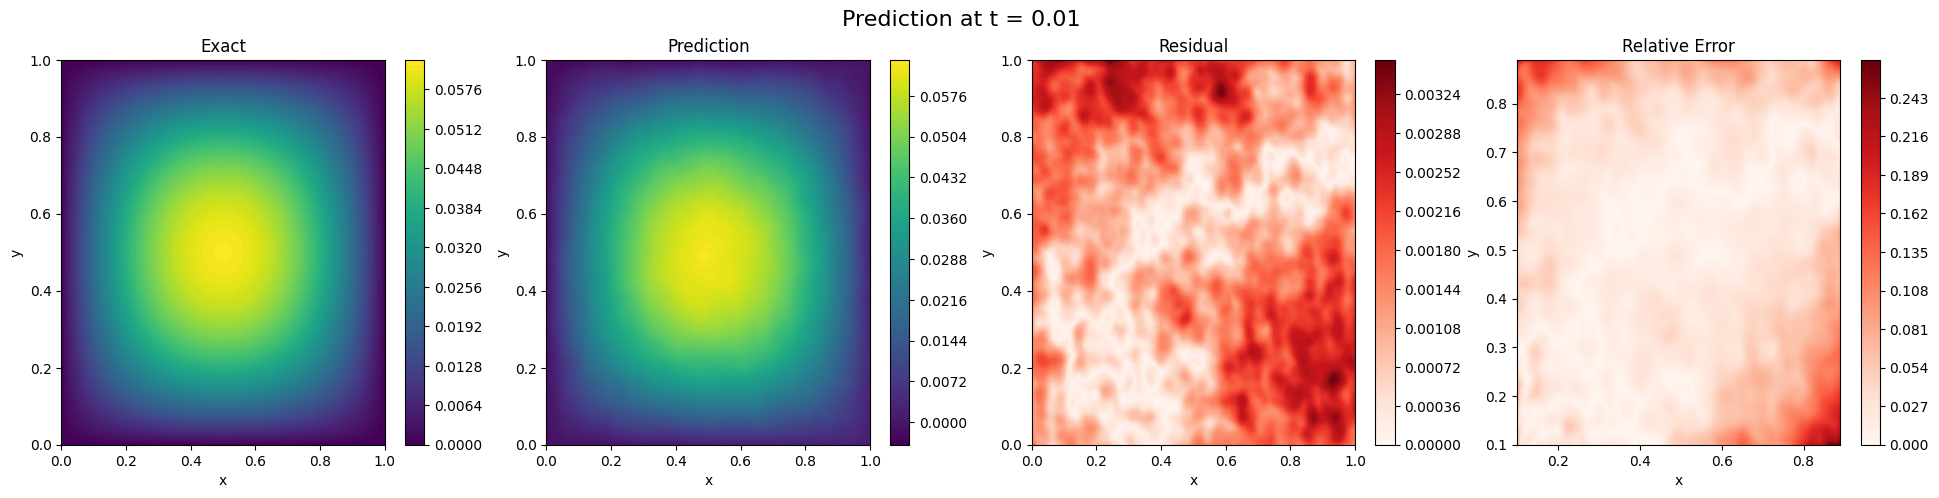

In [19]:
index = 100
index_ext = 10
levels = 100#np.linspace(-0.004,0.075,100)
levels_res = 100
fig,ax=plt.subplots(1,4, figsize = (24,5))
cp0 = ax[0].contourf(xv[:,:,0].reshape((101,101)), yv[:,:,0].reshape((101,101)), u_exact[:,:,index_ext].reshape((101,101)), levels)
cp1 = ax[1].contourf(xv[:,:,0].reshape((101,101)), yv[:,:,0].reshape((101,101)), pred2[:,:,index].reshape((101,101)), levels)
cp2 = ax[2].contourf(xv[:,:,0].reshape((101,101)), yv[:,:,0].reshape((101,101)), np.abs((u_exact[:,:,index_ext].reshape((101,101)) - pred2[:,:,index].reshape((101,101)))), levels_res, cmap=cm.Reds)
cp3 = ax[3].contourf(xv[10:90,10:90,0].reshape((80,80)), yv[10:90,10:90,0].reshape((80,80)), np.abs((u_exact[10:90,10:90,index_ext].reshape((80,80)) - pred2[10:90,10:90,index].reshape((80,80)))/u_exact[10:90,10:90,index_ext].reshape((80,80))), 1000, cmap=cm.Reds)

fig.colorbar(cp3, ax=ax[3])
fig.colorbar(cp2, ax=ax[2])
fig.colorbar(cp1, ax=ax[1])
fig.colorbar(cp0, ax=ax[0])

ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[2].set_xlabel('x')
ax[2].set_ylabel('y')
ax[3].set_xlabel('x')
ax[3].set_ylabel('y')

ax[0].set_title('Exact')
ax[1].set_title('Prediction')
ax[2].set_title('Residual')
ax[3].set_title('Relative Error')
fig.suptitle(r'Prediction at t = 0.01', fontsize=16)